In [2]:
import pandas as pd
import numpy as np
from math import ceil
import time
import glob,os
import re
import matplotlib.pyplot as plt
import pickle
import pdb
import seaborn as sns

DesignID=pd.read_csv('/home/arash/VRrawdata/OptDesign.csv',sep=',',header=1)            
#experiment design codes for adults
DesignID=DesignID.drop(columns=['Unnamed: 0'],axis=1)

googleforms=pd.read_csv('/home/arash/VRrawdata/Google Forms/PED-AV Questionnaire.csv',sep=',',header=0)
with open('/home/arash/ProjectVR/cleaneddata/experiments', 'rb') as f:
    experiments = pickle.load(f)

googleforms.columns

ALLDATA=pd.DataFrame(index=range(len(experiments)),
                     columns=['File','Scenario','Wait Time (s)',
                              'Card ID', 'Speed Limit', 'Lane Width', 'Minimum Gap',
                              'Full Braking Before Impact', 'Mean Arrival Rate', 'Road Type',
                              'Day or Night', 'Weather', 'AV','name', 'Age', 'Gender', 'Occupation',
                              'Education', 'driving license','numcars', 'mode', 'workwalk', 'shopwalk',
                              'numwalk', 'Vrexp', 'Vrexpnum', 'Heart', 'vision', 'anxiety',
                              'Headaches', 'dizziness','starttime'])

for n in range(len(experiments)):
    if not 1<= experiments[n]['scenario'][0] <87:         #check if the scenario is valid
        ALLDATA.iloc[n,0]=experiments[n]['filename'][0]
        ALLDATA.iloc[n,31]='Err3'            #error 3: scenario is not valid
        continue
    pindex=(experiments[n].index[experiments[n]['status']=='u ']).tolist()
    #indces of pedestrians in the experiment dataset

    for index, item in enumerate(pindex):                                      
        #adding time to all u, L, R and NaN rows
        if index>1:
            experiments[n].iloc[pindex[index-1]:pindex[index],7]=experiments[n].iloc[pindex[index-1],7]
    experiments[n].iloc[max(pindex):,7]=experiments[n].iloc[max(pindex),7]        

    #wait time calculation
    if len(experiments[n]['status'][experiments[n]['status']=='L0 '])>0:     
        #to check if first car appears at all
        firstcarL=experiments[n]['status'][experiments[n]['status']=='L0 '].index[0]    
        #index of first car on L lane
    else:
        firstcarL=99999999
        
    if len(experiments[n]['status'][experiments[n]['status']=='R0 '])>0:
        firstcarR=experiments[n]['status'][experiments[n]['status']=='R0 '].index[0]  
        #index of first car on R lane
    else:
        firstcarR=99999999
        
    firstcar=min(firstcarL,firstcarR)                #index of first car appearing
    
    if firstcar<99999998:
        firstcarappeartime=float(experiments[n].iloc[firstcar,7])      #time of first car appearing
        firstcarname=(experiments[n].iloc[firstcar,0])                  #is the fisrt car L0 or R0
        firstcary0=experiments[n].iloc[firstcar,1]                         #y of first car
            

        if firstcary0>experiments[n].iloc[0,1]:  #to determine direction of first car
            if experiments[n][experiments[n]['status']==
                              firstcarname][experiments[n]['y']<experiments[n].iloc[0,1]].shape[0]>0:                   #to check if user has waited for the 1st car to pass
                firstcartime = float(experiments[n].iloc[experiments[n][experiments[n]['status']==
                                                                        firstcarname][experiments[n]['y']<experiments[n].iloc[0,1]].index[0]-1,7])    #time first car passes the pedestrian, users are only allowed to start crossing after first car passed
                firstcarindex=[experiments[n][experiments[n]['status']==
                                              firstcarname][experiments[n]['y']<experiments[n].iloc[0,1]].index[0]]
            else:
                firstcartime=99999999
        else:
            if experiments[n][experiments[n]['status']==firstcarname][experiments[n]['y']>experiments[n].iloc[0,1]].shape[0]>0:
                firstcartime=float(experiments[n].iloc[experiments[n][experiments[n]['status']==firstcarname][experiments[n]['y']>experiments[n].iloc[0,1]].index[0]-1,7])
                firstcarindex=[experiments[n][experiments[n]['status']==firstcarname][experiments[n]['y']>experiments[n].iloc[0,1]].index[0]]
            else:
                firstcartime=99999999

        if firstcartime<99999998:
            pedafter1st=[i for i in pindex if i >= (firstcarindex[0])-1]                    
            #indices of pedestrians after 1st car passed
            lastpedbefore1st=[i for i in pindex if i < (firstcarindex[0])-1]
            #lastpedbefore1st=lastpedbefore1st[len(lastpedbefore1st)-1]                       
            if experiments[n].iloc[pedafter1st][pd.to_numeric(experiments[n]['x'])<(float(experiments[n]['x'][0])-0.2)].shape[0]==0:
                ALLDATA.iloc[n,0]=experiments[n]['filename'][0]
                ALLDATA.iloc[n,1]='Err4'
                ALLDATA.iloc[n,2]='Err4'    #error 4: user does not start crossing
                ALLDATA.iloc[n,3:13]='Err4' #ALLDATA.loc[n,5:22]=='Err4'#DesignID[DesignID['Card ID']==experiments[n]['scenario'][0]].iloc[0,:].values                      
                ALLDATA.iloc[n,13:31]='Err4'
                ALLDATA.iloc[n,31]='Err4'
                continue
            else:
                pedstartmovetime=float(experiments[n].iloc[pedafter1st][pd.to_numeric(experiments[n]['x'])<(float(experiments[n]['x'][0])-0.2)]['timeelaspsed'].tolist()[0])    #time when pedestrian has started walking, measured as the point that the distance from starting point exceeds 0.2 m
                pedstartmoveindex=experiments[n].iloc[pedafter1st][pd.to_numeric(experiments[n]['x'])<(float(experiments[n]['x'][0])-0.2)].index[0]

                waittime=pedstartmovetime-firstcartime
                if 'ACCIDENT' in set(experiments[n]['status']):
                    pet=0
                    distance=1000
                else:
                    if firstcarL==99999999:
                        pet=0
                        distance=1000
                    else:
                        if experiments[n].iloc[pindex][pd.to_numeric(experiments[n]['x'])<(float(experiments[n]['x'][firstcarL+1]))].shape[0]==0:
                            ALLDATA.iloc[n,0]=experiments[n]['filename'][0]
                            ALLDATA.iloc[n,1]=experiments[n]['scenario'][0]
                            ALLDATA.iloc[n,2]= waittime                     #error 5: user does not finish crossing 1st lane
                            ALLDATA.iloc[n,31]=pedstartmovetime
 
                ALLDATA.iloc[n,0]=experiments[n]['filename'][0]
                ALLDATA.iloc[n,1]=experiments[n]['scenario'][0]
                ALLDATA.iloc[n,2]=waittime
                ALLDATA.iloc[n,3:13]=DesignID[DesignID['Card ID']==experiments[n]['scenario'][0]].iloc[0,:].values
                if len(googleforms[googleforms['name']==experiments[n]['name'][0]])>0:
                        ALLDATA.iloc[n,13:31]=googleforms[googleforms['name']==experiments[n]['name'][0]].iloc[0,:].values
                else:
                    ALLDATA.iloc[n,13:31]='NA'
                    ALLDATA.iloc[n,31]=pedstartmovetime

        else:
            ALLDATA.iloc[n,0]=experiments[n]['filename'][0]
            ALLDATA.iloc[n,1]=experiments[n]['scenario'][0]
            ALLDATA.iloc[n,2]='Err2'             #error 2: pedestrian has crossed before 1st car has passed
            ALLDATA.iloc[n,31]=pedstartmovetime
            ALLDATA.iloc[n,3:13]=DesignID[DesignID['Card ID']==experiments[n]['scenario'][0]].iloc[0,:].values
            if len(googleforms[googleforms['name']==experiments[n]['name'][0]])>0:
                ALLDATA.iloc[n,13:31]=googleforms[googleforms['name']==experiments[n]['name'][0]].iloc[0,:].values
            else:
                ALLDATA.iloc[n,13:31]='NA'
    else:
        ALLDATA.iloc[n,0]=experiments[n]['filename'][0]
        ALLDATA.iloc[n,1]=experiments[n]['scenario'][0]
        ALLDATA.iloc[n,2]='Err1'       #error 1: pedestrian has crossed before any car appeared
        ALLDATA.iloc[n,3]='Err1'
        ALLDATA.iloc[n,4]='Err1' 
        ALLDATA.iloc[n,31]='Err1'
        ALLDATA.iloc[n,3:13]=DesignID[DesignID['Card ID']==experiments[n]['scenario'][0]].iloc[0,:].values
        if len(googleforms[googleforms['name']==experiments[n]['name'][0]])>0:
            ALLDATA.iloc[n,13:31]=googleforms[googleforms['name']==experiments[n]['name'][0]].iloc[0,:].values
        else:
            ALLDATA.iloc[n,13:31]='NA'


with open('/home/arash/ProjectVR/cleaneddata/figdata', 'wb') as f:
    pickle.dump(ALLDATA,f)

ALLDATA.columns

data = ALLDATA[['Wait Time (s)', 'Speed Limit','Lane Width', 
                  'Minimum Gap', 'Full Braking Before Impact',
                  'Mean Arrival Rate', 'Road Type', 'Day or Night',
                  'Weather', 'AV', 'Age', 'Gender', 'Occupation', 
                  'Education', 'driving license', 'numcars', 'mode',
                  'workwalk', 'shopwalk', 'Vrexp']]
def AVfix(row):
    if row['AV']>0 and row['AV']<100:
        return 'Mixed' 
    else:
        if row['AV'] == 0:
            return 'HDV'
        else:
            return 'FAV'
        
def NumCarFix(row):
    if int(row['#Cars Owned'])>1:
        return '>1'
    else:
        return str(row['#Cars Owned'])
    
def BrakeFix(row):
    brake = float(row['Full Braking Before Impact'])
    if brake ==-1:
        return 'HDV'
    else:
        if brake == 0.5:
            return '1'
        else:
            if brake == 1:
                return '2'
            else:
                return '3'
            
def AgeFix(row):
    age = row['Age']
    if (age == '18 - 24' or age == '25 - 29'):
        return '18-29'
    else:
        if (age == '50 - 59' or age == '60+'):
            return 'Over 50'
        else:
            return age.replace(" ", "")
        
def DenseFix(row):
    dense = row['Density']
    if (dense<15.1):
        return 'Low'
    else:
        if (dense<22.1):
            return 'Medium'
        else:
            return 'High'

def RoadFix(row):
    rtype = row['Road Type']
    if (rtype=='Two way with median'):
        return 'With Median'
    else:
        return rtype

def ModeFix(row):
    mtype = row['Main Mode']
    if (mtype=='Public Transit'):
        return 'Public'
    else:
        return mtype

data['mode'].unique()

data=data.loc[-data['Wait Time (s)'].isin(['Err1','Err2','Err3','Err4','Err5'])]
data = data.loc[~data['Occupation'].isin(['kids','NA'])]
data = data.loc[~data['shopwalk'].isin(['kid'])]

data['AV'] = data.apply (lambda row: AVfix(row), axis=1)
data['Full Braking Before Impact'] = data.apply (lambda row: BrakeFix(row), axis=1)
data['Density']=data['Mean Arrival Rate']/data['Speed Limit']  
#Min density, veh/km
data['Density'] = data.apply (lambda row: DenseFix(row), axis=1)
data['Road Type'] = data.apply (lambda row: RoadFix(row), axis=1)




data['Wait Time (s)'].plot.hist(grid=True, bins=200, rwidth=0.9,
                   color='#607c8e')
plt.title('freq')
plt.xlabel('Counts')
plt.ylabel('Wait Time')
plt.grid(axis='y', alpha=0.75)

data = data[data['Wait Time (s)']<=20]
data['Wait Time (s)'] = data['Wait Time (s)'].astype(float)

data = data.rename(columns={'AV': 'Automation Status', 'Minimum Gap': 'Gap Time',
                    'Mean Arrival Rate':'Arrival Rate', 
                    'Full Braking Before Impact': 'Braking Levels',
                    'Day or Night':'Time', 'mode': 'Main Mode',
                    'workwalk': 'Walk to Work', 'shopwalk':'Walk to Shop',
                    'Vrexp': 'Previous VR Experience', 'numcars': '#Cars Owned',
                    'driving license': 'Driving License'
                    })



datanoNA = data.loc[~data['Driving License'].isin(['NA'])]
#datanoNA = datanoNA.loc[~datanoNA['Gender'].isin(['NA'])]
datanoNA['#Cars Owned'] = datanoNA.apply (lambda row: NumCarFix(row), axis=1)
datanoNA['Age'] = datanoNA.apply (lambda row: AgeFix(row), axis=1)
datanoNA['Main Mode'] = datanoNA.apply (lambda row: ModeFix(row), axis=1)


data['Density'].unique()

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:109: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3

/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:88: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:98: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/arash/anaconda3/

array(['Low', 'Medium', 'High'], dtype=object)

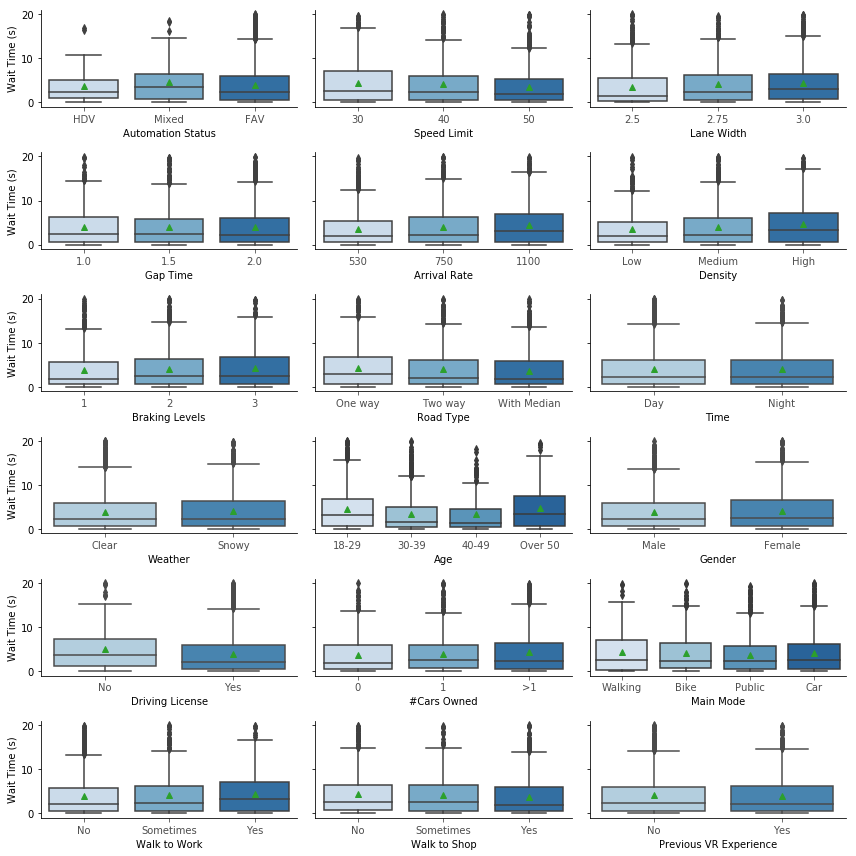

In [6]:
f, axes = plt.subplots(6, 3, figsize=(12, 12),sharey='row')
sns.despine(left=False)
sns.set_style({'axes.labelcolor': '0.0','xtick.color': '.3'})

sns.boxplot(x=data['Automation Status'], y=data['Wait Time (s)'],
            order = ['HDV','Mixed','FAV'],palette="Blues",ax=axes[0, 0],showmeans=True)
sns.boxplot(x=data['Speed Limit'], y=data['Wait Time (s)'], palette="Blues",ax=axes[0, 1]
            ,showmeans=True).set(ylabel='')
sns.boxplot(x=data['Lane Width'], y=data['Wait Time (s)'], palette="Blues",ax=axes[0, 2]
            ,showmeans=True).set(ylabel='')
sns.boxplot(x=data['Gap Time'], y=data['Wait Time (s)'], palette="Blues",ax=axes[1, 0],showmeans=True)
sns.boxplot(x=data['Arrival Rate'], y=data['Wait Time (s)'], palette="Blues",ax=axes[1, 1],showmeans=True).set(ylabel='')
sns.boxplot(x=data['Density'], y=data['Wait Time (s)'], palette="Blues",ax=axes[1, 2],
            showmeans=True).set(ylabel='')
sns.boxplot(x=data['Braking Levels'], y=data['Wait Time (s)'],
            order=['1','2','3'],palette="Blues",ax=axes[2, 0],showmeans=True)
sns.boxplot(x=data['Road Type'], y=data['Wait Time (s)']
            ,order=['One way','Two way','With Median'],palette="Blues",ax=axes[2, 1],showmeans=True).set(ylabel='')
sns.boxplot(x=data['Time'], y=data['Wait Time (s)'], palette="Blues",ax=axes[2, 2],
           order = ['Day','Night'],showmeans=True).set(ylabel='')

sns.boxplot(x=data['Weather'], y=data['Wait Time (s)'], palette="Blues",ax=axes[3, 0],showmeans=True)
sns.boxplot(x=datanoNA['Age'], y=datanoNA['Wait Time (s)'], palette="Blues",ax=axes[3, 1],showmeans=True
           ,order = ['18-29','30-39','40-49','Over 50']).set(ylabel='')
sns.boxplot(x=datanoNA['Gender'], y=datanoNA['Wait Time (s)'], palette="Blues",ax=axes[3, 2],showmeans=True).set(ylabel='')
sns.boxplot(x=datanoNA['Driving License'], y=datanoNA['Wait Time (s)'], palette="Blues",ax=axes[4, 0],
           order = ['No','Yes'],showmeans=True)

sns.boxplot(x=datanoNA['#Cars Owned'], y=datanoNA['Wait Time (s)'], palette="Blues",ax=axes[4, 1]
           ,order = ['0','1','>1'],showmeans=True).set(ylabel='')

sns.boxplot(x=datanoNA['Main Mode'], y=datanoNA['Wait Time (s)'], palette="Blues",ax=axes[4,2],
           order = ['Walking','Bike','Public','Car'],showmeans=True).set(ylabel='')

sns.boxplot(x=datanoNA['Walk to Work'], y=datanoNA['Wait Time (s)'], palette="Blues",ax=axes[5, 0],
           showmeans=True,order = ['No','Sometimes','Yes'])

sns.boxplot(x=datanoNA['Walk to Shop'], y=datanoNA['Wait Time (s)'], palette="Blues",ax=axes[5, 1],
           order = ['No', 'Sometimes', 'Yes'],showmeans=True).set(ylabel='')
sns.boxplot(x=datanoNA['Previous VR Experience'], y=datanoNA['Wait Time (s)'], palette="Blues",
            ax=axes[5, 2],showmeans=True).set(ylabel='')
plt.tight_layout()

plt.savefig('comparison.pdf')





<Figure size 432x288 with 0 Axes>